# EO data cleaning

In [12]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [13]:
import pickle
import re
# import numpy as np
from pathlib import Path

import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from eolearn.core import EOPatch
from sentinelhub import CRS
from shapely.geometry import Polygon

In [14]:
DATA_PATH = Path(r'E:\Data\PerceptiveSentinel\SVN\2017\processed\patches')
# DATA_PATH = Path(r'E:\Data\PerceptiveSentinel\Slovenia')
# DATA_PATH = Path(r'E:\Data\PerceptiveSentinel\Slovenia_backup')
# DATA_PATH = Path(r'E:\Data\PerceptiveSentinel\LULC\processed')
COUNTRIES_PATH = Path('..', 'data', 'external', 'countries', 'ne_10m_admin_0_countries.shp')

## Check for missing eopatches, mising data, ...

In [17]:
indices = []
missing = []

for patch_path in DATA_PATH.iterdir():
    match = re.match(r'^eopatch_(\d+)$', patch_path.name)

    # Check if directory name matches pattern.
    if not match or not patch_path.is_dir():
        print(f'Skipping: {patch_path.name}')
        continue

    # Get directory index.
    idx = int(match.group(1))
    indices.append(idx)

    # Check if certain files exist.
    paths = {
        'bbox':             patch_path / 'bbox.pkl',
        'meta_info':        patch_path / 'meta_info.pkl',
        'timestamp':        patch_path / 'timestamp.pkl',
        'BANDS':            patch_path / 'data' / 'BANDS.npy',
        'CLP':              patch_path / 'data' / 'CLP.npy',
        'ARVI':             patch_path / 'data' / 'ARVI.npy',
        'BLUE':             patch_path / 'data' / 'BLUE.npy',
        'EVI':              patch_path / 'data' / 'EVI.npy',
        'GRAY':             patch_path / 'data' / 'GRAY.npy',
        'GREEN':            patch_path / 'data' / 'GREEN.npy',
        'NDVI':             patch_path / 'data' / 'NDVI.npy',
        'NDWI':             patch_path / 'data' / 'NDWI.npy',
        'NIR':              patch_path / 'data' / 'NIR.npy',
        'RED':              patch_path / 'data' / 'RED.npy',
        'SAVI':             patch_path / 'data' / 'SAVI.npy',
        'SIPI':             patch_path / 'data' / 'SIPI.npy',
        'DEM':              patch_path / 'data_timeless' / 'DEM.npy',
        'INCLINATION':      patch_path / 'data_timeless' / 'INCLINATION.npy',
        'CLM':              patch_path / 'mask' / 'CLM.npy',
        'IS_DATA':          patch_path / 'mask' / 'IS_DATA.npy',
        'IS_DATA':          patch_path / 'mask' / 'IS_VALID.npy',
        'EDGES_INV':        patch_path / 'mask_timeless' / 'EDGES_INV.npy',
        'LULC_2020':        patch_path / 'mask_timeless' / 'LULC_2020.npy',
        'LULC_2020_E':      patch_path / 'mask_timeless' / 'LULC_2020_E.npy',
        'LULC_2020_G':      patch_path / 'mask_timeless' / 'LULC_2020_G.npy',
        'LULC_2020_G_E':    patch_path / 'mask_timeless' / 'LULC_2020_G_E.npy',
        'LULC_2017':        patch_path / 'mask_timeless' / 'LULC_2017.npy',
        'LULC_2017_E':      patch_path / 'mask_timeless' / 'LULC_2017_E.npy',
        'LULC_2017_G':      patch_path / 'mask_timeless' / 'LULC_2017_G.npy',
        'LULC_2017_G_E':    patch_path / 'mask_timeless' / 'LULC_2017_G_E.npy'
    }

    for key, path in paths.items():
        if not path.is_file():
            missing.append(idx)
            print(f'File not found: {path}')
            # with open(patch_path / 'timestamp.pkl', 'rb') as fp:
            #     timestamp = pickle.load(fp)
            #     print(f'Timestamp: {len(timestamp)}')
            

# Check for missing indices.
indices = np.array(indices)

for i in range(0, indices.max()):
    if i not in indices:
        print(f'Eopatch not found: eopatch_{i}')

print(f'Missing files: {len(missing)}')
missing.sort()
print(missing)

Missing files: 0
[]


## Plot bounding boxes of eopaches

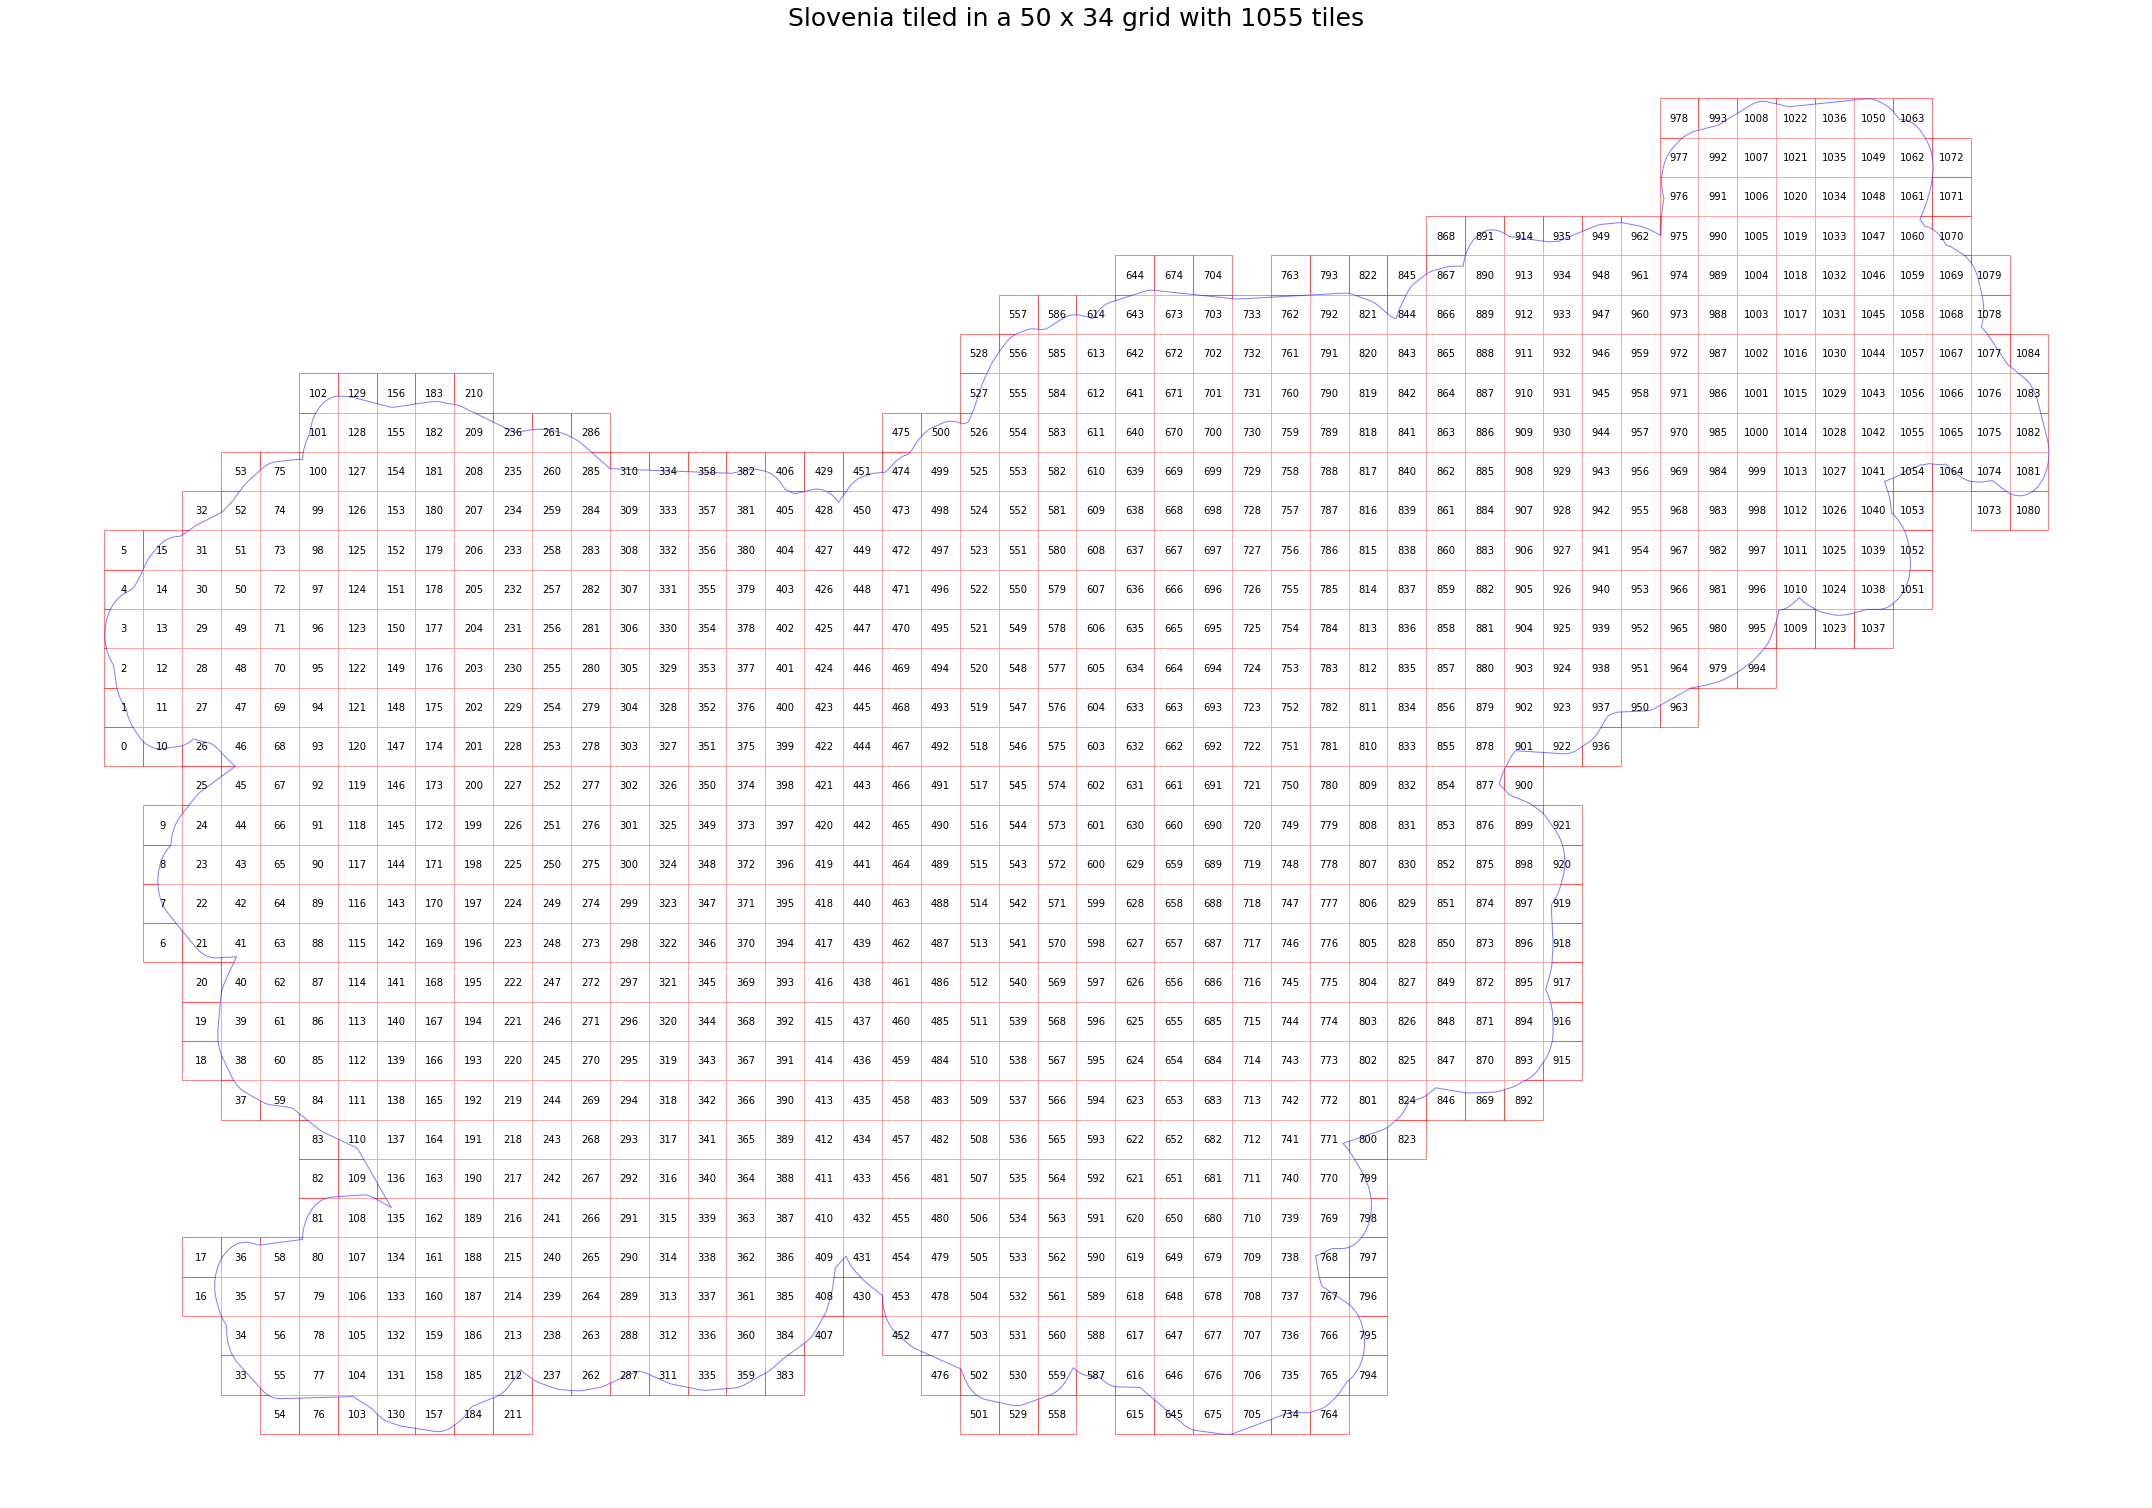

In [10]:
geometry = []
index = []

# Get bounding boxes from eopatches
for patch_path in DATA_PATH.iterdir():
    match = re.match(r'^eopatch_(\d+)$', patch_path.name)

    # Check if directory name matches pattern.
    if not match or not patch_path.is_dir():
        print(f'Skipping: {patch_path.name}')
        continue

    # Get directory index.
    index.append(int(match.group(1)))

    # Load bounding box data.
    bbox_path = patch_path / 'bbox.pkl'
    with open(str(bbox_path), 'rb') as fh:
        bbox = pickle.load(fh)
        geometry.append(Polygon(bbox.get_polygon()))


# Prepare GeoDataFrame for country
country_crs = CRS['UTM_33N']
countries = gpd.read_file(COUNTRIES_PATH)
country = countries.loc[countries['SOV_A3'] == 'SVN']
country.geometry = country.geometry.buffer(0.05).tolist()
country = country.to_crs(crs=country_crs.pyproj_crs())

# Prepare GeoDataFrame for tiles
tiles = gpd.GeoDataFrame(
    crs=country.crs, 
    geometry=geometry
)

# Plot country and tiles
fig, ax = plt.subplots(figsize=(30, 30))
tiles.plot(ax=ax, facecolor='w', edgecolor='r', alpha=0.5)
country.plot(ax=ax, facecolor='w', edgecolor='b', alpha=0.5)
ax.set_title(f'Slovenia tiled in a 50 x 34 grid with {len(indices)} tiles', fontsize=25)
for idx, bbox in zip(index, geometry):
    ax.text(bbox.centroid.x, bbox.centroid.y, idx, ha='center', va='center')

plt.axis('off')
plt.tight_layout()
plt.savefig('./figures/Slovenia_processed.png')
plt.savefig('./figures/Slovenia_processed.svg')

## Check DEM and INCLINATION dimensions

In [11]:
indices = []
broken = []

for patch_path in DATA_PATH.iterdir():
    match = re.match(r'^eopatch_(\d+)$', patch_path.name)

    # Check if directory name matches pattern.
    if not match or not patch_path.is_dir():
        print(f'Skipping: {patch_path.name}')
        continue

    # Get directory index.
    idx = int(match.group(1))
    indices.append(idx)

    dem_path = patch_path / 'data_timeless' / 'DEM.npy'
    inc_path = patch_path / 'data_timeless' / 'INCLINATION.npy'

    state = []
    if not dem_path.is_file():
        state.append('missing DEM')
    else:
        shape = np.load(dem_path).shape
        if shape[0] != 505 or shape[1] != 500:
            state.append('wrong DEM dimensions')

    if not inc_path.is_file():
        state.append('missing INCLINATION')
    else:
        shape = np.load(inc_path).shape
        if shape[0] != 505 or shape[1] != 500:
            state.append('wrong INCLINATION dimensions')

    if len(state):
        broken.append((idx, state))


# Check for missing indices.
indices = np.array(indices)

for i in range(0, indices.max()):
    if i not in indices:
        broken.append((i, ['missing DEM', 'missing INCLINATION']))

broken.sort(key=lambda e: e[0])

for k, v in broken:
    print(f'{k}: {v}')

broken_indices = [e[0] for e in broken]
print(broken_indices)

[]


## Check and fix metadata

In [5]:
indices = []

for patch_path in DATA_PATH.iterdir():
    match = re.match(r'^eopatch_(\d+)$', patch_path.name)

    # Check if directory name matches pattern.
    if not match or not patch_path.is_dir():
        print(f'Skipping: {patch_path.name}')
        continue

    # Get directory index.
    idx = int(match.group(1))
    indices.append(idx)

    meta_info = None
    with open(patch_path / 'meta_info.pkl', 'rb') as fp:
        meta_info = pickle.load(fp)
    
    # If service type is invalid fix meta properties.
    if meta_info['service_type'] == 'processing':
        print(f'Meta info [{idx}]: {meta_info["service_type"]}')

        meta_info['service_type'] = 'wcs'
        meta_info['size_x'] = '10m'
        meta_info['size_y'] = '10m'
        meta_info['time_interval'] = ['2017-01-01', '2017-12-31']
        
        with open(patch_path / 'meta_info.pkl', 'wb') as fp:
            pickle.dump(meta_info, fp, protocol=pickle.HIGHEST_PROTOCOL)


Skipping: shapefiles
